In [176]:
import keras

from keras import layers
# from keras import ops
# from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio
import tensorflow as tf
print(tf.__version__)

import numpy as np
import imageio, os
from gan_model import CGAN
from utils import generate_and_save_images
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


import imgaug.augmenters as iaa

2.13.0


### Defining the discriminator and generator architectures

In [177]:

def make_discriminator_model(discriminator_in_channels):
    # Create the discriminator.
    discriminator = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer((28, 28, discriminator_in_channels)),
            layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
            layers.LeakyReLU(0.2),
            layers.GlobalMaxPooling2D(),
            layers.Dense(1),
        ],
        name="discriminator",
    )
    return discriminator

def make_generator_model(generator_in_channels):
# Create the generator.
    generator = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer((generator_in_channels,)),
            # We want to generate 128 + num_classes coefficients to reshape into a
            # 7x7x(128 + num_classes) map.
            layers.Dense(7 * 7 * generator_in_channels),
            layers.LeakyReLU(0.2),
            layers.Reshape((7, 7, generator_in_channels)),
            layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
        ],
        name="generator",
    )
    return generator

### Defining parameters

In [178]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
RANDOM_STATE=42

In [179]:
model_path = "./gan_model/gan_model.keras"
os.makedirs(model_path, exist_ok=True)
model_dir = os.path.dirname(model_path)

### Compiling the model

In [180]:
checkpoint_path = "training/gan.ckpt"
os.makedirs(checkpoint_path, exist_ok=True)
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

In [181]:
cgan = CGAN(
    discriminator=make_discriminator_model(discriminator_in_channels), 
    generator=make_generator_model(generator_in_channels), latent_dim=latent_dim, 
    image_size=image_size, num_classes=num_classes
)

cgan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

### Loading the data

In [182]:
import cv2
import random
random.seed(RANDOM_STATE)

aug_seq = iaa.Sequential([
            iaa.Rotate((-10, 10), random_state=RANDOM_STATE),                 
            iaa.ShearX((-10, 10), random_state=RANDOM_STATE),                  
            iaa.ShearY((-10, 10), random_state=RANDOM_STATE),
        ])

def augment(image):
    kernel = np.ones((2, 2), np.uint8) 
    if random.random() < 0.5:
        image = cv2.erode(image, kernel, iterations=1) 
    else:
        image = cv2.dilate(image, kernel, iterations=1) 
    image = aug_seq.augment_image(image)
    return image

/var/folders/p_/k4rcs6js04923d1w5fcqv7dc0000gn/T/ipykernel_66521/1929739733.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[i for i in range(10)])


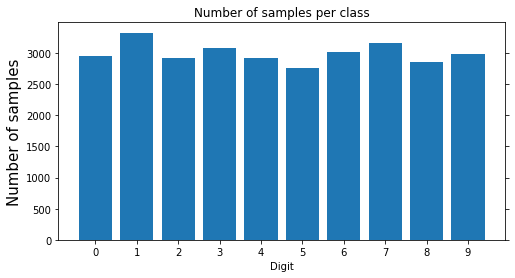

Number of training samples: 27000
Number of validation samples: 3000
Number of testing samples: 10000


In [183]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
_, x_train, _, y_train = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

plt.rcParams['figure.figsize'] = [8, 4]
fig, ax = plt.subplots(nrows=1, ncols=1)

unique, counts = np.unique(y_train, return_counts=True)

barWidth = 0.2
br1 = np.arange(len(counts)) 

ax.bar(br1, counts)
ax.set_xticklabels(labels=[i for i in range(10)])
ax.tick_params(left = True, right = True , labelleft = True , 
                labelbottom = True, bottom = True) 
plt.xticks([r  for r in range(len(counts))])
plt.ylabel('Number of samples', fontsize = 15) 
plt.xlabel('Digit')
plt.title('Number of samples per class')
plt.show()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify=y_train) 

print("Number of training samples:", len(x_train))
print("Number of validation samples:", len(x_val))
print("Number of testing samples:", len(x_test))

# all_digits = np.concatenate([x_train, x_test])
# all_labels = np.concatenate([y_train, y_test])

In [184]:
import matplotlib.pyplot as plt

def plot_mnist_samples(data, f_name):
    plt.rcParams['figure.figsize'] = [6, 6]
    f, axarr = plt.subplots(5,5)

    idx = 0
    for i_row in range(5):
        for j_col in range(5):
            img = data[idx]
            axarr[i_row][j_col].imshow(img, cmap='gray')
            idx += 1
            axarr[i_row][j_col].tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    plt.savefig(f_name, dpi=300)
    plt.show()

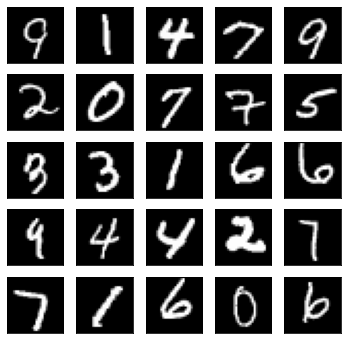

In [185]:
plot_mnist_samples(x_train, 'mnist_samples.png')

In [186]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 2660,
 1: 2996,
 2: 2628,
 3: 2769,
 4: 2637,
 5: 2490,
 6: 2720,
 7: 2842,
 8: 2571,
 9: 2687}

### Preprocessing

* Rescaling to [0-1]
* 1-hot encoding of labels
* augmentation (rotation, shearing)

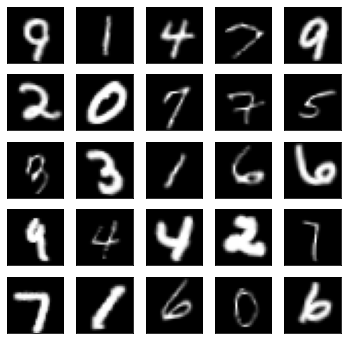

In [187]:
x_train_aug = np.asarray([augment(x) for x in x_train.astype("float32")])
plot_mnist_samples(x_train_aug, 'mnist_samples_aug.png')

In [188]:
x_train_aug = x_train_aug.astype("float32") / 255.0

x_train = x_train.astype("float32") / 255.0

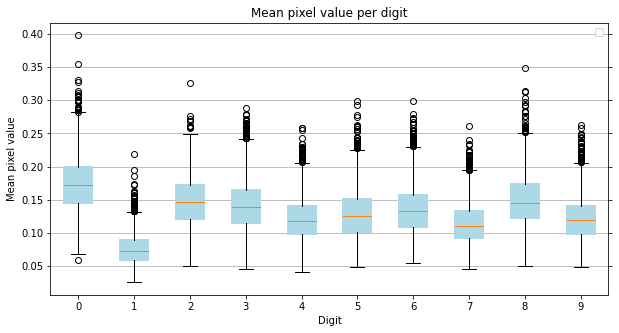

In [189]:
means_dict = {}
for i in range(10):
    means_dict[i] = []

for idx in range(len(x_train)):
    img =  x_train[idx]
    label = y_train[idx]
    means_dict[label].append(np.mean(img))


plt.rcParams['figure.figsize'] = [10, 5]

fig, ax = plt.subplots(nrows=1, ncols=1)
box = ax.boxplot([means_dict[i] for i in range(10)], patch_artist=True)
for box_ in box['boxes']:
    box_.set(color='lightblue', linewidth=2)
    box_.set(facecolor = 'lightblue' )

ax.set_ylabel('Mean pixel value')
ax.set_xlabel('Digit')
ax.set_title('Mean pixel value per digit')
ax.set_xticklabels(labels=[i for i in range(10)])
ax.tick_params(left = True, right = True , labelleft = True , 
                labelbottom = True, bottom = True) 
plt.legend()
plt.grid(axis = 'y')
plt.savefig('mnist_gan_boxplot.png', dpi=300)
plt.show()

In [190]:
aug=True
if aug:
    x_train = np.concatenate([x_train, np.array(x_train_aug)])
    y_train = np.concatenate([y_train, y_train])

In [191]:
means_dict = {}
for i in range(10):
    means_dict[i] = []

for idx in range(len(x_train)):
    img =  x_train[idx]
    label = y_train[idx]
    means_dict[label].append(np.mean(img))

plt.rcParams['figure.figsize'] = [10, 5]

fig, ax = plt.subplots(nrows=1, ncols=1)
box = ax.boxplot([means_dict[i] for i in range(10)], patch_artist=True)
for box_ in box['boxes']:
    box_.set(color='lightblue', linewidth=2)
    box_.set(facecolor = 'lightblue' )

ax.set_ylabel('Mean pixel value')
ax.set_xlabel('Digit')
ax.set_title('Mean pixel value per digit')
ax.set_xticklabels(labels=[i for i in range(10)])
ax.tick_params(left = True, right = True , labelleft = True , 
                labelbottom = True, bottom = True) 
plt.legend()
plt.grid(axis = 'y')
plt.savefig('mnist_gan_boxplot_aug.png', dpi=300)
plt.show()

In [ ]:
x_train = np.reshape(x_train, (-1, 28, 28, 1))
y_train = tf.keras.utils.to_categorical(y_train, 10)

x_val = x_val.astype("float32") / 255.0
x_val = np.reshape(x_val, (-1, 28, 28, 1))
y_val = tf.keras.utils.to_categorical(y_val, 10)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {x_train.shape}")
print(f"Shape of training labels: {y_train.shape}")

Shape of training images: (54000, 28, 28, 1)
Shape of training labels: (54000, 10)


### Training the models

In [ ]:
epochs = 30
cgan.compiled_metrics == None

cgan.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

cgan.generator.save("mnist_gan.keras")

Epoch 1/30
844/844 [==============================] - 310s 367ms/step - g_loss: 1.3929 - d_loss: 0.4544 - val_g_loss: 1.4470 - val_d_loss: 0.2549
Epoch 2/30
844/844 [==============================] - 311s 368ms/step - g_loss: 1.6479 - d_loss: 0.3995 - val_g_loss: 2.1285 - val_d_loss: 0.1829
Epoch 3/30
844/844 [==============================] - 321s 380ms/step - g_loss: 2.3739 - d_loss: 0.2504 - val_g_loss: 2.7609 - val_d_loss: 0.1540
Epoch 4/30
844/844 [==============================] - 328s 388ms/step - g_loss: 2.8485 - d_loss: 0.1694 - val_g_loss: 3.3907 - val_d_loss: 0.1631
Epoch 5/30
764/844 [==========================>...] - ETA: 32s - g_loss: 3.1621 - d_loss: 0.1220

KeyboardInterrupt: 

### Generating images

tf.Tensor([18 10], shape=(2,), dtype=int32)
tf.Tensor([ 18 128], shape=(2,), dtype=int32)
tf.Tensor([ 18 128], shape=(2,), dtype=int32)


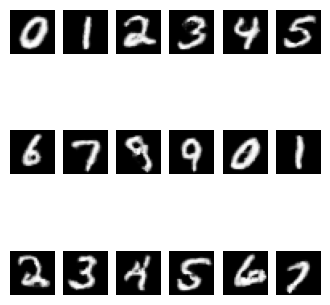

In [ ]:
cgan = tf.keras.models.load_model("mnist_gan.keras")

labels = [i%10 for i in range(18)]
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes)
print(tf.shape(one_hot_labels))

# Sample random points in the latent space.
random_latent_vectors = tf.random.normal(
    shape=(18, latent_dim), seed=1337
)
print(tf.shape(random_latent_vectors))

random_vector_labels = tf.concat(
    [random_latent_vectors, one_hot_labels], axis=1
)

print(tf.shape(random_latent_vectors))

# Generate after the final epoch
generate_and_save_images(cgan,
                        epochs,
                        random_vector_labels)